# 3  -Data cleansing

The data cleansing process includes the treatment of the data to achieve completeness and reduce the bias caused by errors in the data.

Data cleansing includes:

○ Treatment of outliers

○ Treatment of missingness

In [1]:
# Import libraries:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import iqr
from scipy import stats
from scipy.stats import ks_2samp
from itertools import combinations
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Using the ODBC:
""" 
driver_name = "SQL Server Native Client 11.0"
server = "ITZIK\SQLEXPRESS"
dbname = "Berlin"
"""

' \ndriver_name = "SQL Server Native Client 11.0"\nserver = "ITZIK\\SQLEXPRESS"\ndbname = "Berlin"\n'

In [3]:
#Expanding the output display to see more rows and columns:
pd.set_option('display.max_rows', 200 , 'display.max_columns', 200)

In [4]:

#read the data:
"""
conn = pyodbc.connect('Driver={};'
                      'Server={};'
                      'Database={};'
                      'Trusted_Connection=yes;'.format(driver_name, server, dbname))




df = pd.read_sql_query('SELECT * FROM db01.FINAL_TABLE',conn)
"""
df = pd.read_csv("flat_file.csv")

In [5]:
#Displaying the first 3 rows of dataframe using head() method:
df.head(3)

,Unnamed: 0,listing_id,name,target_start_date_period,target_end_date_period,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,target_avg_dollar_price_in_period,start_date_previous_period,end_date_previous_period,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,last_scraped,summary,space,description,experiences_offered,notes,transit,access,interaction,house_rules,neighborhood_overview,host_about,host_since,DaysPassed_host_since,picture_url,host_url,host_location,host_response_time,host_response_rate,host_acceptance_rate,xl_picture_url,medium_url,thumbnail_url,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,market,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,first_review,DaysPassed_first_review,calendar_last_scraped,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,concat_comments,size,concat_comments_polarity,concat_comments_subjectivity,concat_comments_sentiment
0,0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2019-02-01,2019-04-30,89,0,0,76.5168,2018-11-07,2019-01-31,86,39,0.45,92.6808,2217,Ian,Mitte,Brunnenstr. S��d,52.534537,13.402557,Entire home/apt,60.0,4.0,118.0,2018-10-28,1030.0,3.76,4.0,141.0,https://www.airbnb.com/rooms/2015,2018-11-07,Great location! 30 of 75 sq meters. This wood...,A+++ location! This ���Einliegerwohnung��� is ...,Great location! 30 of 75 sq meters. This wood...,none,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",It is located in the former East Berlin area o...,Believe in sharing economy.,2008-08-18,4753.0,https://a0.muscache.com/im/pictures/260fd609-7...,https://www.airbnb.com/users/show/2217,"Key Biscayne, Florida, United States",within an hour,0.96,NaN,NaN,NaN,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Brunnenstr. S��d,Mitte,Berlin,Berlin,10119.0,"Berlin, Germany",Berlin,DE,Germany,f,Guesthouse,3.0,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,NaN,NaN,$200.00,$30.00,1.0,$28.00,1125.0,3 months ago,0.0,21.0,51.0,2016-04-11,1960.0,2018-11-07,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,f,f,f,f,strict_14_with_grace_period,##������������ ��������� ��������� ������ ����...,75.0,0.358553,0.560576,positive_sentiment
1,1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2019-03-01,2019-05-31,92,26,0,76.6212,2018-11-07,2019-02-28,114,39,0.34,86.5466,2217,Ian,Mitte,Brunnenstr. S��d,52.534537,13.402557,Entire home/apt,60.0,4.0,118.0,2018-10-28,1030.0,3.76,4.0,141.0,https://www.airbnb.com/rooms/2015,2018-11-07,Great location! 30 of 75 sq meters. This wood...,A+++ location! This ���Einliegerwohnung��� is ...,Great location! 30 of 75 sq meters. This wood...,none,"This is my home, not a hotel. I rent out occas...","Cl

In [6]:
df["listing_id"] = df["listing_id"].astype('int')
df["host_id"] = df["host_id"].astype('int')

In [7]:
# Reading from sql add some additional index columns that starts with "Unamed" - dropping this columns
columns_to_drop = [x for x in df.columns.to_list() if x.startswith("Unnamed")]
print("dropping coulmns: ", columns_to_drop) # [Unamed..., Unamed..]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

dropping coulmns:  ['Unnamed: 0']


In [8]:
# Displaying variables cleaning_fee, extra_people, security_deposit
df[['cleaning_fee', 'extra_people', 'security_deposit']].head(5)

,cleaning_fee,extra_people,security_deposit
0,$30.00,$28.00,$200.00
1,$30.00,$28.00,$200.00
2,$30.00,$28.00,$200.00
3,$30.00,$28.00,$200.00
4,$30.00,$28.00,$200.00


In [9]:
#For exploration, removing the "$"-Sign and formatting as float of vars cleaning_fee, extra_people, security_deposit
df.cleaning_fee.fillna('$0.00', inplace=True)
df.extra_people.fillna('$0.00', inplace=True)
df.security_deposit.fillna('$0.00', inplace=True)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [10]:
# fixed!
df[['cleaning_fee', 'extra_people', 'security_deposit']].head(5)

,cleaning_fee,extra_people,security_deposit
0,30.0,28.0,200.0
1,30.0,28.0,200.0
2,30.0,28.0,200.0
3,30.0,28.0,200.0
4,30.0,28.0,200.0


In [11]:
# Arrange the columns by type

def get_dict_of_df_types(pdf: pd.DataFrame) -> dict:
    """
    Arrange dataframe columns in the dictionary by types:
    For each type having a list of columns
    """
    d_of_columns_types = {}

    for c,t in zip(pdf.columns, pdf.dtypes):
        t_str = str(t)
        if d_of_columns_types.get(t_str) == None:
            d_of_columns_types[t_str] = [c]
        else:
            d_of_columns_types[t_str].append(c)
    return d_of_columns_types

In [12]:
d_of_columns_types_local = get_dict_of_df_types(df)
d_of_columns_types_local

{'int32': ['listing_id', 'host_id'],
 'object': ['name',
  'target_start_date_period',
  'target_end_date_period',
  'start_date_previous_period',
  'end_date_previous_period',
  'host_name',
  'neighbourhood_group',
  'neighbourhood',
  'room_type',
  'last_review',
  'listing_url',
  'last_scraped',
  'summary',
  'space',
  'description',
  'experiences_offered',
  'notes',
  'transit',
  'access',
  'interaction',
  'house_rules',
  'neighborhood_overview',
  'host_about',
  'host_since',
  'picture_url',
  'host_url',
  'host_location',
  'host_response_time',
  'host_is_superhost',
  'host_thumbnail_url',
  'host_picture_url',
  'host_neighbourhood',
  'host_verifications',
  'host_has_profile_pic',
  'host_identity_verified',
  'street',
  'neighbourhood_cleansed',
  'neighbourhood_group_cleansed',
  'city',
  'state',
  'smart_location',
  'market',
  'country_code',
  'country',
  'is_location_exact',
  'property_type',
  'bed_type',
  'amenities',
  'weekly_price',
  'monthly

In [13]:
numeric_list = d_of_columns_types_local['int64'] + d_of_columns_types_local['float64']
numeric_list

['target_num_of_day_in_period',
 'target_num_of_booked_days',
 'booked_up_target',
 'num_of_day_in_previous_period',
 'num_of_booked_days_in_previous_period',
 'target_avg_dollar_price_in_period',
 'occupancy_last_period',
 'avg_dollar_price_in_previous_period',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'DaysPassed_last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'DaysPassed_host_since',
 'host_response_rate',
 'host_acceptance_rate',
 'xl_picture_url',
 'medium_url',
 'thumbnail_url',
 'host_total_listings_count',
 'zipcode',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'DaysPassed_first_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communicati

# outliers check

In this section, We are searching for significant outliers in numeric variables.
We check each variable to determine if it has outliers and which values are considered outliers.

The methodology of the treatment in the outliers will be:

1. If the outliers is a mistaken observation - replacing the outliers with na.
2. If the outliers generate any false correlation with the outcome - replacing the outliers with na.
3. If the removal of the outliers change the distribution of the outcome but not the correlation - replacing the outliers with na.
4. If the removal of the outliers change the both correlation and the distribution of the outcome - we can't replace the outliers with na. In this case we will need to perform a data transformation or make the variable categorical and thus divide it into groups that one of which will be "missing" or use models to predict the missing variables.

This methodology is based on the findings we found in the EDA section.

In [14]:
def iqr_outliers_matrix(df_src: pd.DataFrame, numeric_col_list: list, threshold=1.5):
    """
    Creating a new binary matrix base on numeric_col_list in df_src.
    For each value in each column in numeric_col_list, if the value is out of range of column iqr we set as it outlier 
    """
    df_outliers = pd.DataFrame()
    for numeric_col in numeric_col_list:
        # for each col we get interquartile range. 
        out_low = df_src[numeric_col].quantile(.25) # like getting 25% from describe()
        out_high = df_src[numeric_col].quantile(.75) #  # like getting 75% from describe()
        # iqr is interquartile range * 1.5
        iqr_level = (out_high - out_low) * threshold

        out_low = out_low - iqr_level
        out_high = out_high +  iqr_level
        # for each value in each col, we are set 1 if it the value is outlier in the column and 0 otherwise
        df_outliers[numeric_col] = df_src[numeric_col].apply(lambda x: 1 if ((x <out_low) or (x>out_high))  else 0)
    return df_outliers



In [15]:
# this list conatins numeric list, 
# that in EDA stage I decided that all values in this columns are legitimate and we don't need to treat them as outliers
numeric_columns_with_legitimate_values = ["target_num_of_day_in_period", "num_of_booked_days_in_previous_period", "num_of_day_in_previous_period", "occupancy_last_period",
                                          "target_num_of_booked_days", "bathrooms", "beds", "zipcode", "review_scores_rating",
                                          "review_scores_accuracy","review_scores_cleanliness", "review_scores_checkin", 
                                          "review_scores_communication", "review_scores_location", "review_scores_value",
                                          "availability_30", "availability_60", "availability_90", "jurisdiction_names" , 
                                          "availability_365", "longitude", "latitude", "host_response_rate", "medium_url", "thumbnail_url"]

numeric_selected_colums = [col for col in numeric_list if col not in numeric_columns_with_legitimate_values]

In [16]:
# For each value in each of col in the list:
# 0 - standard value in column
# 1 - Outlier value in the column
df_outliers = iqr_outliers_matrix(df, numeric_selected_colums, 1.5)
df_outliers.head()

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_acceptance_rate,xl_picture_url,host_total_listings_count,accommodates,bedrooms,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df_outliers.describe()

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_acceptance_rate,xl_picture_url,host_total_listings_count,accommodates,bedrooms,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
count,157864.0,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.0,157864.0,157864.000000,157864.000000,157864.000000,157864.000000,157864.00000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000,157864.000000
mean,0.0,0.018592,0.031305,0.055339,0.109081,0.126995,0.056979,0.066158,0.235633,0.001463,0.0,0.0,0.084737,0.083673,0.238116,0.000355,0.08926,0.025053,0.225302,0.018712,0.000798,0.016939,0.043854,0.056181,0.061103
std,0.0,0.135079,0.174142,0.228641,0.311742,0.332969,0.231804,0.248559,0.424395,0.038225,0.0,0.0,0.278492,0.276898,0.425932,0.018831,0.28512,0.156287,0.417782,0.135507,0.028240,0.129042,0.204771,0.230272,0.239520
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking for differences in the distribution

In [18]:
"""
"checking_differences_distribution"  compare if there are difference between the distribution
of the variable when having the outliers and when the outliers are removed. 
"""

booked_up_target_out=df['booked_up_target']
booked_up_target_non=df['booked_up_target'][df_outliers['booked_up_target']==0]
ks_2samp(booked_up_target_out, booked_up_target_non)


def checking_differences_distribution(df_src: pd.DataFrame, df_outliers_mask: pd.DataFrame) -> pd.DataFrame:
    """
    Compare if there are differences between the distribution of the variable when
    having the outliers and when the outliers are removed, and save the results in a dataframe.
    The function uses Kolmogorov-Smirnov statistics. This is a non-parametric statistic that can be used on variables
    without outliers.
    If the difference (p-value) is significant we will add a plus, While when the p-value is not significant, we will add a minus. 

    """
    results = []
    for col in df_outliers_mask.columns:
        df_col_src = df_src[col]
        df_col_no_outliers = df_src[col][df_outliers_mask[col] == 0]
        src_count = len(df_col_src)
        outlier_count = len(df_col_no_outliers)
        statistic, pvalue = ks_2samp(df_col_src, df_col_no_outliers,mode="asymp")
        res = {"col_name": col, "src_count": src_count, 
               "selected_values_count": outlier_count,
               "outliers_count": src_count-outlier_count, "statistic": statistic, "pvalue": pvalue, 
               "distribution_changed": "+" if pvalue < 0.05 else "-"}
        results.append(res)
    return pd.DataFrame(results)

df_differences_distribution = checking_differences_distribution(df,df_outliers)

In [19]:
df_differences_distribution

,col_name,src_count,selected_values_count,outliers_count,statistic,pvalue,distribution_changed
0,booked_up_target,157864,157864,0,-0.000000,1.000000e+00,-
1,target_avg_dollar_price_in_period,157864,154929,2935,0.013674,4.005465e-13,+
2,avg_dollar_price_in_previous_period,157864,152922,4942,0.016286,2.550224e-18,+
3,price,157864,149128,8736,0.055339,2.091988e-204,+
4,minimum_nights,157864,140644,17220,0.109081,0.000000e+00,+
5,number_of_reviews,157864,137816,20048,0.126995,0.000000e+00,+
6,DaysPassed_last_review,157864,148869,8995,0.046509,2.239617e-144,+
7,reviews_per_month,157864,147420,10444,0.053863,1.590544e-192,+
8,calculated_host_listings_count,157864,120666,37198,0.235633,0.000000e+00,+
9,DaysPassed_host_since,157864,157633,231,0.001462,9.959639e-01,-


In [20]:
def my_spearmanr(df, x1, x2):
    """
    Using the Spearman's rank correlation coefficient test, which is a nonparametric measure of rank correlation.
    """
    df_sub = df[[x1,x2]].dropna(axis=0, inplace=False)
    return stats.spearmanr(df_sub[x1],df_sub[x2])

In [21]:
def checking_correlation(df_src: pd.DataFrame, df_outliers_mask: pd.DataFrame, target_col = "booked_up_target") -> pd.DataFrame:
    """
  Our second test we have to make with the outliers- check if they change the correlation between the variable and the outcome variable.
  We do so using the Spearman's rank correlation coefficient test, which is a nonparametric measure of rank correlation.
  If the correlation is significant (p-value < 0.05) we will add a plus, While when the p-value is not significant, we will add a minus.  
    """
    results = []
    for col in df_outliers_mask.columns:
        if col == target_col: # booked_up_target
            continue
        df_col_src = df_src[col]
        df_col_no_outliers = df_src[df_outliers[col] == 0] 
        src_count = len(df_col_src)
        no_outlier_count = len(df_col_no_outliers)
        correlation_src, pvalue_src = my_spearmanr(df_src, col, target_col)
      
        correlation_no_outliers, pvalue_no_outliers = my_spearmanr(df_col_no_outliers, col, target_col)
        correlation_changed =""
        if (pvalue_src < 0.05 and pvalue_no_outliers <0.05) or (pvalue_src > 0.05 and pvalue_no_outliers > 0.05):
            correlation_changed = "-"
        else:
            correlation_changed = "+"
            
        res = {"col_name": col, 
               "src_count": src_count, 
               "selected_values_count": no_outlier_count,
               "outliers_count": src_count-no_outlier_count, 
               "correlation_src": correlation_src, 
               "pvalue_src": pvalue_src, 
               "correlation_src": correlation_src, 
               "correlation_no_outliers":correlation_no_outliers, 
               "pvalue_no_outliers": pvalue_no_outliers,
               "correlation_changed": correlation_changed}
        results.append(res)
    return pd.DataFrame(results)

df_correlations = checking_correlation(df,df_outliers)

In [22]:
# By joining the two dataframes and checking "correlation_changed" and "distribution_changed", 
# I can decide if I can delete the outliers or not.
# If both distribution_changed and correlation_changed are '+' the drop_outliers will be No (otherwise yes)

df_drop_outliers = df_correlations[['col_name','outliers_count','correlation_changed' ]].merge(df_differences_distribution[['col_name','distribution_changed']],  how='inner', on='col_name')

def drop_outliers_func(_correlation_changed, _distribution_changed):
    if _correlation_changed == '+' and _distribution_changed == '+':
        return "No"
    else:
        return "Yes"
    
df_drop_outliers['drop_outliers'] = df_drop_outliers.apply(lambda x: drop_outliers_func(x.correlation_changed, x.distribution_changed), axis=1)
df_drop_outliers

,col_name,outliers_count,correlation_changed,distribution_changed,drop_outliers
0,target_avg_dollar_price_in_period,2935,+,+,No
1,avg_dollar_price_in_previous_period,4942,-,+,Yes
2,price,8736,-,+,Yes
3,minimum_nights,17220,-,+,Yes
4,number_of_reviews,20048,-,+,Yes
5,DaysPassed_last_review,8995,-,+,Yes
6,reviews_per_month,10444,-,+,Yes
7,calculated_host_listings_count,37198,+,+,No
8,DaysPassed_host_since,231,-,-,Yes
9,host_acceptance_rate,0,+,-,Yes


### My way to removing the outliers and explanation:

If the removal of the outliers change the both correlation and the distribution of the outcome ("No" in the column drop_outliers) - we can't replace the outliers with na. In this case we will need to perform a data transformation or make the variable categorical and thus divide it into groups that one of which will be "missing" or use models to predict the missing variables.

Otherwise, ("Yes" in the column drop_outliers) - replacing the outliers with na, because in all the variables the correlation and the distribution have not changed after I removed the outliers from the variables. 


### Replacing outliers with na

In [23]:
df_drop_outliers

,col_name,outliers_count,correlation_changed,distribution_changed,drop_outliers
0,target_avg_dollar_price_in_period,2935,+,+,No
1,avg_dollar_price_in_previous_period,4942,-,+,Yes
2,price,8736,-,+,Yes
3,minimum_nights,17220,-,+,Yes
4,number_of_reviews,20048,-,+,Yes
5,DaysPassed_last_review,8995,-,+,Yes
6,reviews_per_month,10444,-,+,Yes
7,calculated_host_listings_count,37198,+,+,No
8,DaysPassed_host_since,231,-,-,Yes
9,host_acceptance_rate,0,+,-,Yes


In [24]:
df_outliers

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_acceptance_rate,xl_picture_url,host_total_listings_count,accommodates,bedrooms,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157861,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
def get_outliers_colums_to_remove(_df_drop_outliers: pd.DataFrame):
  
    """  
    _df_drop_outliers is a descrtiption dataframe of outliers in src dataframe which have the following colums:
    1. col_name - pivot of col name from src dataframe to row value in this dataframe. col name contains the cols name in src dataframe
    2. outliers_count - number of outlier in each col_name
    3. correlation_changed - "+"/"-" base on pvalue_src and pvalue_no_outliers ("checking_correlation" function)
    4. distribution_changed -  "+"/"-" base on pvalue ("checking_differences_distribution" function)
    5. drop_outliers - "No"/"Yes" - base on correlation_changed and distribution_changed ("drop_outliers_func" function)
    """
    # return the col_name in all row which have "Yes" in drop_outliers 
    return [row['col_name'] for index,row in _df_drop_outliers.iterrows() if row['drop_outliers'] == 'Yes']

#####################################################################################################
# test get_outliers_colums_to_remove
df_drop_outliers_unit_test = pd.DataFrame({'col_name': ['target_avg_dollar_price_in_period', 'avg_dollar_price_in_previous_period'], 
                                           'outliers_count': [2935, 4942], 
                                           'correlation_changed':['+','-'], 
                                           'distribution_changed':["+", "+"], 
                                           'drop_outliers': ["No", "Yes"] })
print("df_drop_outliers_unit_test:")
display(df_drop_outliers_unit_test)
print("expecting get_outliers_colums_to_remove returns ['avg_dollar_price_in_previous_period']")
assert get_outliers_colums_to_remove(df_drop_outliers_unit_test) == ['avg_dollar_price_in_previous_period']

df_drop_outliers_unit_test:


,col_name,outliers_count,correlation_changed,distribution_changed,drop_outliers
0,target_avg_dollar_price_in_period,2935,+,+,No
1,avg_dollar_price_in_previous_period,4942,-,+,Yes


expecting get_outliers_colums_to_remove returns ['avg_dollar_price_in_previous_period']


In [26]:
df_outliers.head(2)

,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_acceptance_rate,xl_picture_url,host_total_listings_count,accommodates,bedrooms,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
def repalce_outliers_with_na(_df_src, _df_is_outlier, _cols_replace_outliers_with_none):
    """
    using _df_outliers_mask to repalce outliers values in each column with None
    _df_src: flat table
    _df_outliers_mask: having flag/mask table of _df_src which desribe wheter the value is 1 for outlier or 0 for a value in normal ditriburation
    _cols_replace_outliers_with_none: cols to iterate. 
    """
    def _replace_outliers_with_nan(orig_value, is_value_outlier: int):
        """
        using is_value_outlier to decide wheter the new value should be none or the original value
        
        """
        if is_value_outlier == 1:
            return None
        else:
            return orig_value
        
    # _df_outliers_mask has almost the same columns has _df_src
    # replacing the name of col with _COL_is_outliers (otherwise we have duplicates columns names after merges)
    df_is_outlier_2 = _df_is_outlier.add_suffix("_is_outlier")
    # merge the flat table with flags dataframe that desribes if value is outlier or no.
    df_ouliers_2_none = _df_src.merge(df_is_outlier_2, left_index=True, right_index=True)
    for col in _cols_replace_outliers_with_none:
        col_is_outlier = col + "_is_outlier" 
        print(f"replace outiers values of '{col}' with None")
        df_ouliers_2_none[col] = df_ouliers_2_none.apply(lambda x: _replace_outliers_with_nan(x[col], x[col_is_outlier]), axis=1)

    return df_ouliers_2_none


# get columns names which decided to drop there outliers
cols_replace_outliers_with_none = get_outliers_colums_to_remove(_df_drop_outliers=df_drop_outliers)
if 'booked_up_target' in cols_replace_outliers_with_none:
    cols_replace_outliers_with_none.remove('booked_up_target')

print("_df_src: ")
display(df.head(2))
print("_df_is_outlier:" )
display(df_outliers.head(2))
print("_cols_replace_outliers_with_none:", cols_replace_outliers_with_none)
df_all_outliers_na = repalce_outliers_with_na(_df_src=df, _df_is_outlier=df_outliers, _cols_replace_outliers_with_none=cols_replace_outliers_with_none)


_df_src: 


,listing_id,name,target_start_date_period,target_end_date_period,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,target_avg_dollar_price_in_period,start_date_previous_period,end_date_previous_period,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,listing_url,last_scraped,summary,space,description,experiences_offered,notes,transit,access,interaction,house_rules,neighborhood_overview,host_about,host_since,DaysPassed_host_since,picture_url,host_url,host_location,host_response_time,host_response_rate,host_acceptance_rate,xl_picture_url,medium_url,thumbnail_url,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,market,country_code,country,is_location_exact,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,first_review,DaysPassed_first_review,calendar_last_scraped,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,concat_comments,size,concat_comments_polarity,concat_comments_subjectivity,concat_comments_sentiment
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2019-02-01,2019-04-30,89,0,0,76.5168,2018-11-07,2019-01-31,86,39,0.45,92.6808,2217,Ian,Mitte,Brunnenstr. S��d,52.534537,13.402557,Entire home/apt,60.0,4.0,118.0,2018-10-28,1030.0,3.76,4.0,141.0,https://www.airbnb.com/rooms/2015,2018-11-07,Great location! 30 of 75 sq meters. This wood...,A+++ location! This ���Einliegerwohnung��� is ...,Great location! 30 of 75 sq meters. This wood...,none,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",It is located in the former East Berlin area o...,Believe in sharing economy.,2008-08-18,4753.0,https://a0.muscache.com/im/pictures/260fd609-7...,https://www.airbnb.com/users/show/2217,"Key Biscayne, Florida, United States",within an hour,0.96,NaN,NaN,NaN,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Brunnenstr. S��d,Mitte,Berlin,Berlin,10119.0,"Berlin, Germany",Berlin,DE,Germany,f,Guesthouse,3.0,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,NaN,NaN,200.0,30.0,1.0,28.0,1125.0,3 months ago,0.0,21.0,51.0,2016-04-11,1960.0,2018-11-07,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,f,f,f,f,strict_14_with_grace_period,##������������ ��������� ��������� ������ ����...,75.0,0.358553,0.560576,positive_sentiment
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2019-03-01,2019-05-31,92,26,0,76.6212,2018-11-07,2019-02-28,114,39,0.34,86.5466,2217,Ian,Mitte,Brunnenstr. S��d,52.534537,13.402557,Entire home/apt,60.0,4.0,118.0,2018-10-28,1030.0,3.76,4.0,141.0,https://www.airbnb.com/rooms/2015,2018-11-07,Great location! 30 of 75 sq meters. This wood...,A+++ location! This ���Einliegerwohnung��� is ...,Great location! 30 of 75 sq meters. This wood...,none,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and 

_df_is_outlier:


,booked_up_target,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,DaysPassed_host_since,host_acceptance_rate,xl_picture_url,host_total_listings_count,accommodates,bedrooms,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,DaysPassed_first_review,size,concat_comments_polarity,concat_comments_subjectivity
0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


_cols_replace_outliers_with_none: ['avg_dollar_price_in_previous_period', 'price', 'minimum_nights', 'number_of_reviews', 'DaysPassed_last_review', 'reviews_per_month', 'DaysPassed_host_since', 'host_acceptance_rate', 'xl_picture_url', 'host_total_listings_count', 'accommodates', 'square_feet', 'security_deposit', 'cleaning_fee', 'extra_people', 'maximum_nights', 'DaysPassed_first_review', 'size', 'concat_comments_polarity', 'concat_comments_subjectivity']
replace outiers values of 'avg_dollar_price_in_previous_period' with None
replace outiers values of 'price' with None
replace outiers values of 'minimum_nights' with None
replace outiers values of 'number_of_reviews' with None
replace outiers values of 'DaysPassed_last_review' with None
replace outiers values of 'reviews_per_month' with None
replace outiers values of 'DaysPassed_host_since' with None
replace outiers values of 'host_acceptance_rate' with None
replace outiers values of 'xl_picture_url' with None
replace outiers values 

replace_outliers_dict_of_df = {}
for col_name in cols_to_remove:
    replace_outliers_dict_of_df[col_name] = repalce_outliers_with_na(_df_src=df, _df_outliers_mask=df_outliers, _cols=[col_name])

replace_outliers_dict_of_df

In [28]:
# Checking if the number of rows not changed
len(df_all_outliers_na)

157864

###  Distribution before and after remmoving outliers:

<Figure size 432x288 with 0 Axes>

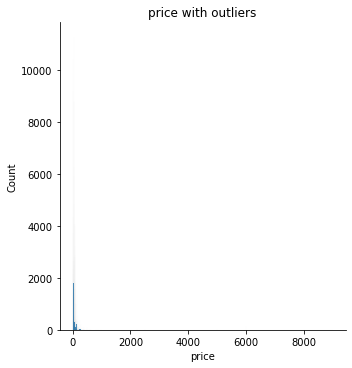

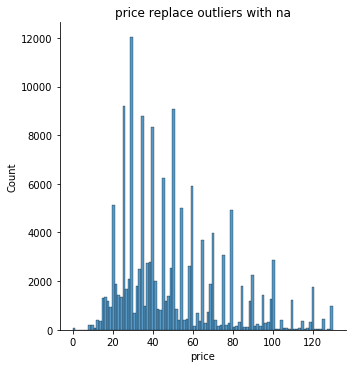

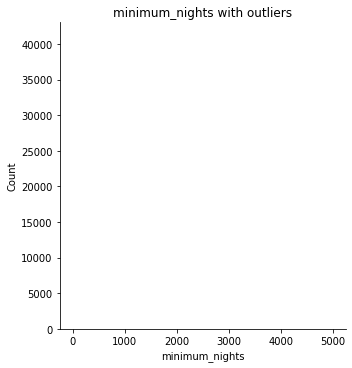

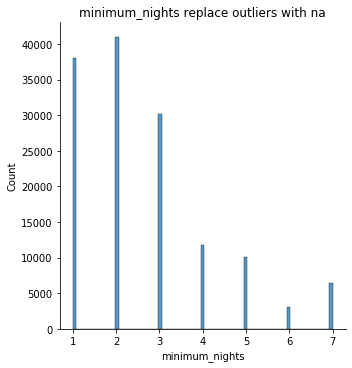

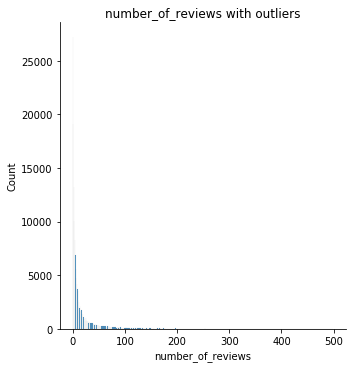

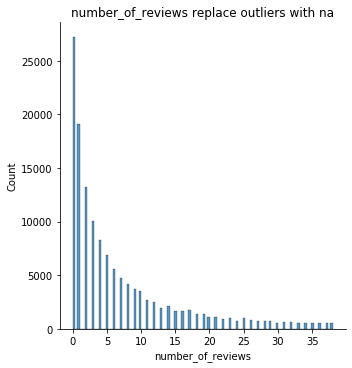

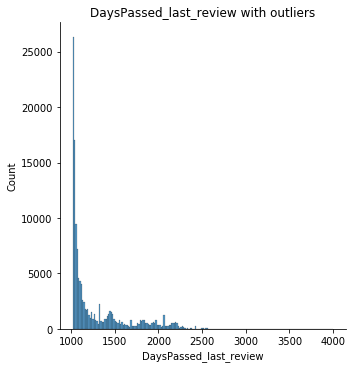

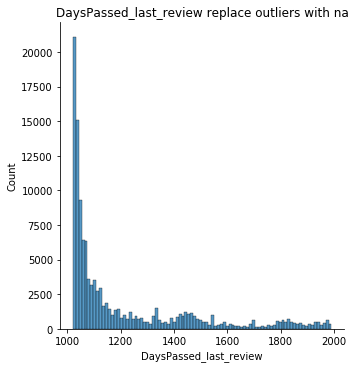

In [32]:
plt.figure()
for col_name in cols_replace_outliers_with_none[1:5]:
    sns.displot(df, x=col_name).set(title= f'"{col_name}" col with outliers')
    sns.displot(df_all_outliers_na, x=col_name).set(title= f'"{col_name}" col replace outliers with na')

In [35]:
def seaborn_displot_replace_col_with_outliers(_df_orig, _df_all_outliers_na, cols_list):
    plt.figure()
    for col_name in cols_list:
        sns.displot(_df_orig, x=col_name).set(title= f'"{col_name}" col with outliers')
        sns.displot(_df_all_outliers_na, x=col_name).set(title= f'"{col_name}" col replace outliers with na')
    pass

In [42]:
cols_replace_outliers_with_none[5:10]

['reviews_per_month',
 'DaysPassed_host_since',
 'host_acceptance_rate',
 'xl_picture_url',
 'host_total_listings_count']

<Figure size 432x288 with 0 Axes>

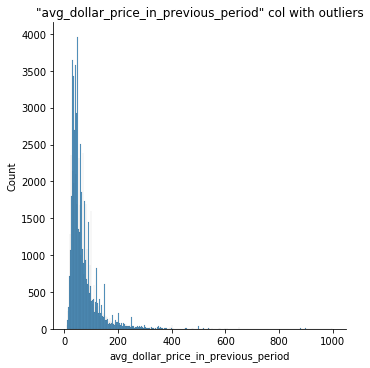

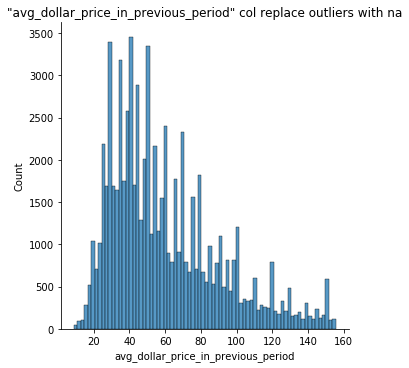

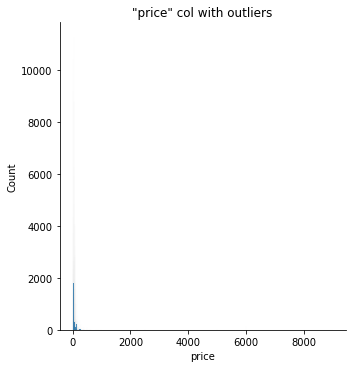

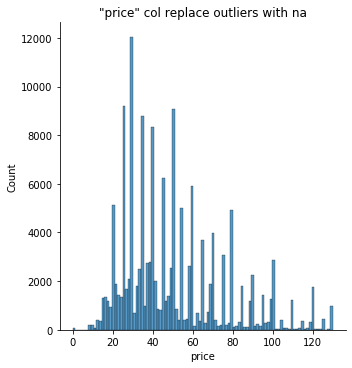

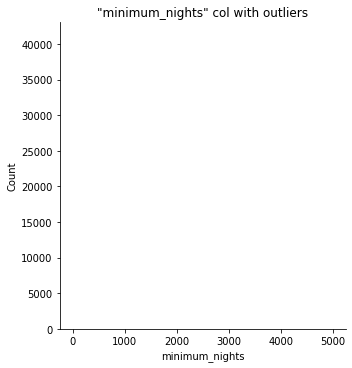

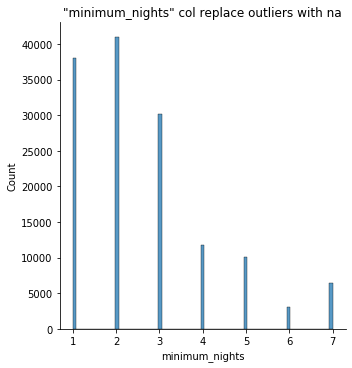

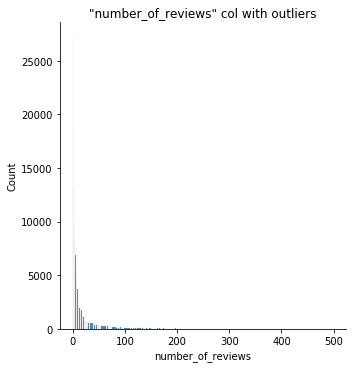

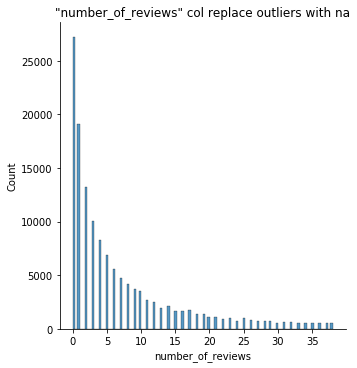

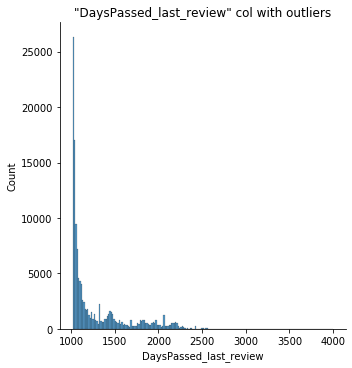

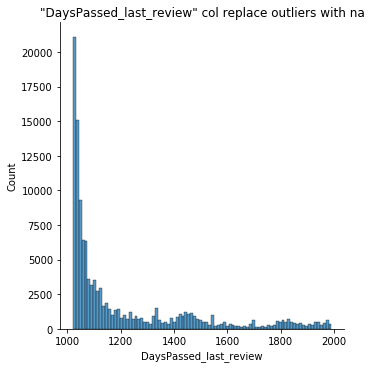

In [43]:
seaborn_displot(_df_orig=df, _df_all_outliers_na=df_all_outliers_na, cols_list=cols_replace_outliers_with_none[0:5])

<Figure size 432x288 with 0 Axes>

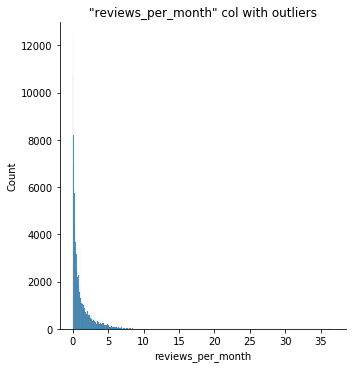

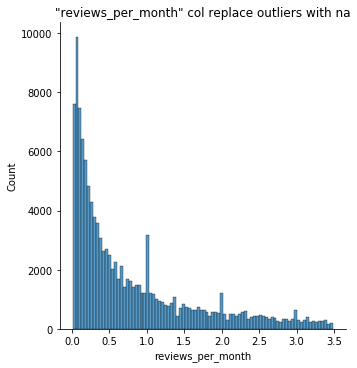

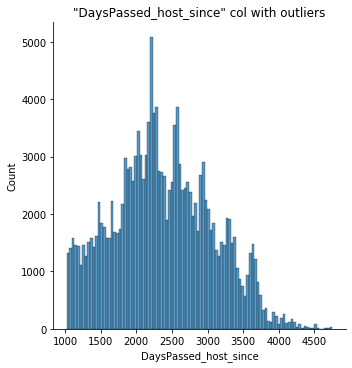

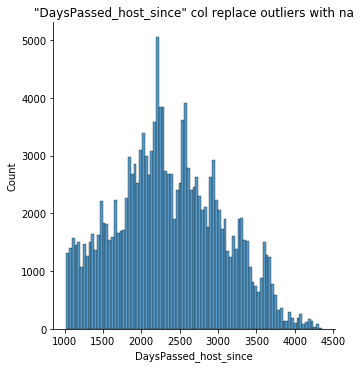

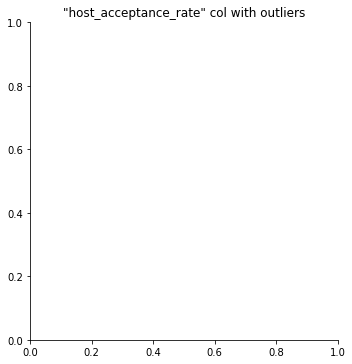

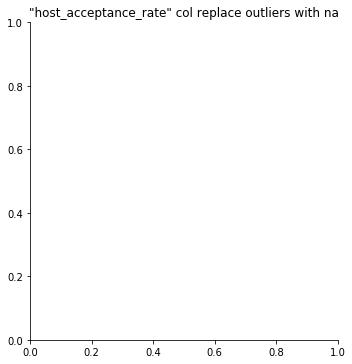

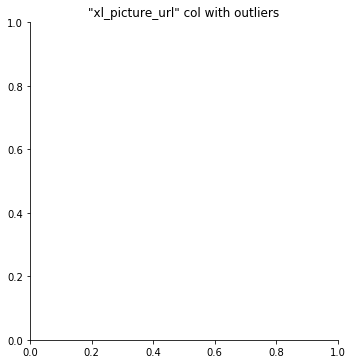

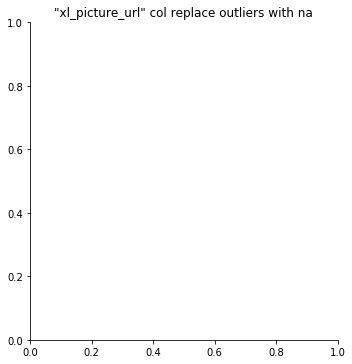

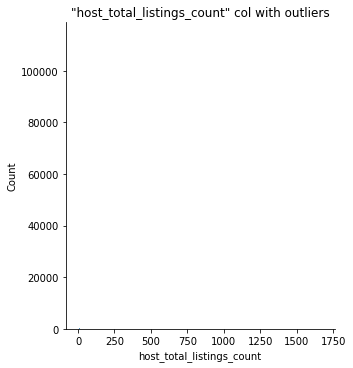

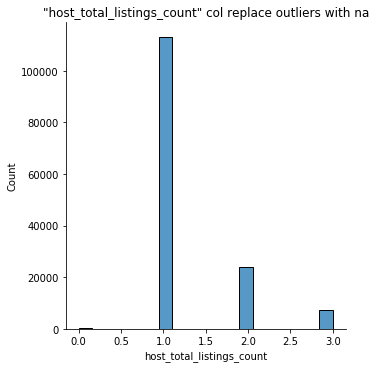

In [44]:
seaborn_displot(_df_orig=df, _df_all_outliers_na=df_all_outliers_na, cols_list=cols_replace_outliers_with_none[5:10])

<Figure size 432x288 with 0 Axes>

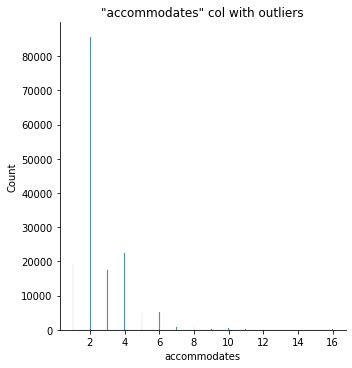

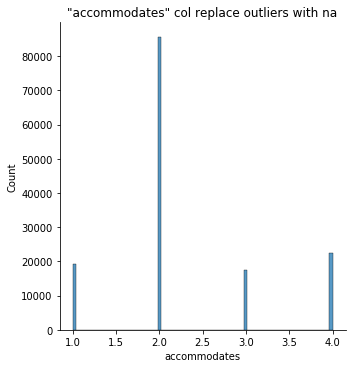

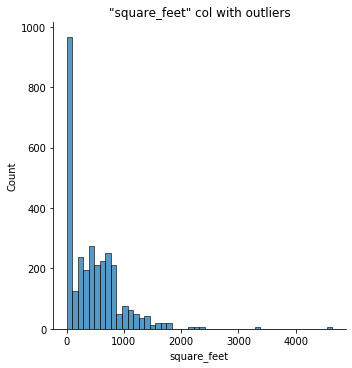

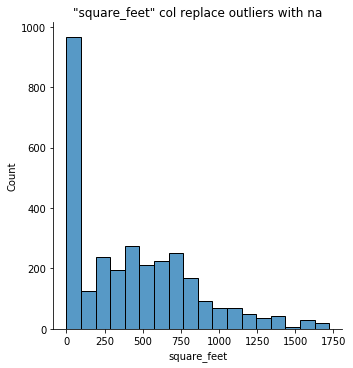

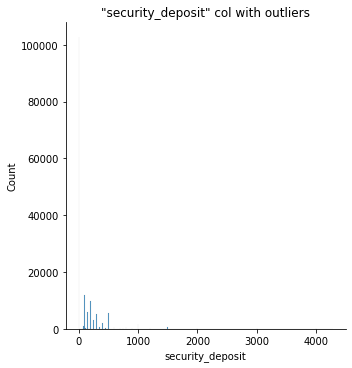

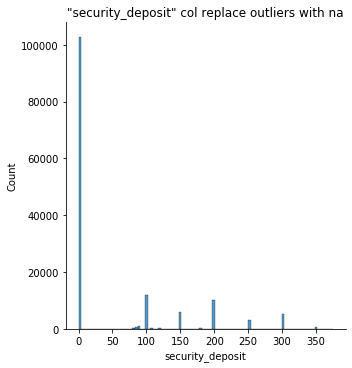

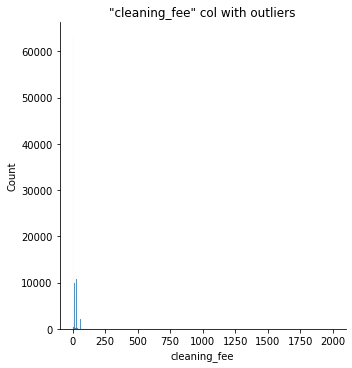

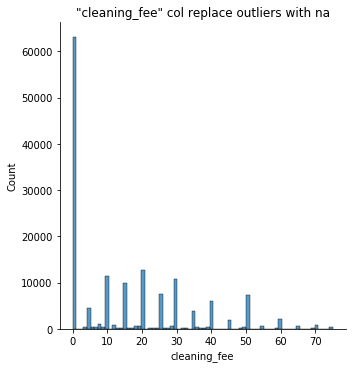

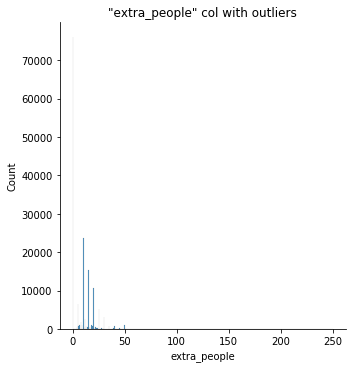

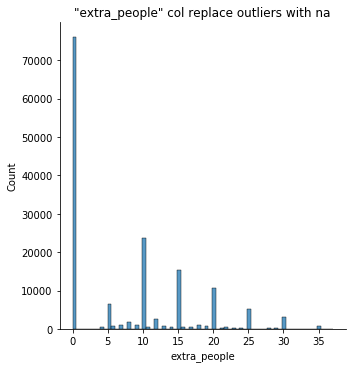

In [45]:
seaborn_displot(_df_orig=df, _df_all_outliers_na=df_all_outliers_na, cols_list=cols_replace_outliers_with_none[10:15])

In [ ]:
seaborn_displot(_df_orig=df, _df_all_outliers_na=df_all_outliers_na, cols_list=cols_replace_outliers_with_none[15:])

In [ ]:
plt.figure()
for col in numeric_selected_colums:
    sns.displot(df, x=col)

                               "review_scores_rating",
                                          "review_scores_accuracy","review_scores_cleanliness", "review_scores_checkin", 
                                          "review_scores_communication", "review_scores_location", "review_scores_value",
                                          "availability_30", "availability_60", "availability_90", "jurisdiction_names" , 
                                          "availability_365", "longitude", "latitude", "host_response_rate", "medium_url", "thumbnail_url"    sns.displot(df_all_outliers_na, x=col) 

In [ ]:



plt.figure()

sns.displot(df, x='target_avg_dollar_price_in_period')
sns.displot(df_all_outliers_na, x='target_avg_dollar_price_in_period')
sns.displot(df, x='avg_dollar_price_in_previous_period')
sns.displot(df_all_outliers_na, x='avg_dollar_price_in_previous_period')
sns.displot(df, x='price')
sns.displot(df_all_outliers_na, x='price')
sns.displot(df, x='minimum_nights')
sns.displot(df_all_outliers_na, x='minimum_nights')
sns.displot(df, x='number_of_reviews')
sns.displot(ddf_all_outliers_na, x='number_of_reviews')
sns.displot(df, x='DaysPassed_last_review')
sns.displot(df_all_outliers_na, x='DaysPassed_last_review')
sns.displot(df, x='reviews_per_month')
sns.displot(df_all_outliers_na, x='reviews_per_month')
sns.displot(df, x='calculated_host_listings_count')
sns.displot(df_all_outliers_na, x='calculated_host_listings_count')
sns.displot(df, x='host_response_rate')
sns.displot(df_all_outliers_na, x='host_response_rate')
sns.displot(df, x='host_total_listings_count')
sns.displot(df_all_outliers_na, x='host_total_listings_count')
sns.displot(df, x='accommodates')
sns.displot(df_all_outliers_na, x='accommodates')
sns.displot(df, x='bedrooms')
sns.displot(df_all_outliers_na, x='bedrooms')
sns.displot(df, x='square_feet')
sns.displot(df_all_outliers_na, x='square_feet')
sns.displot(df, x='security_deposit')
sns.displot(df_all_outliers_na, x='security_deposit')
sns.displot(df, x='cleaning_fee')
sns.displot(df_all_outliers_na, x='cleaning_fee')
sns.displot(df, x='guests_included')
sns.displot(df_all_outliers_na, x='guests_included')
sns.displot(df, x='extra_people')
sns.displot(df_all_outliers_na, x='extra_people')
sns.displot(df, x='maximum_nights')
sns.displot(df_all_outliers_na, x='maximum_nights')
sns.displot(df, x='review_scores_rating')
sns.displot(df_all_outliers_na, x='review_scores_rating')
sns.displot(df, x='review_scores_accuracy')
sns.displot(df_all_outliers_na, x='review_scores_accuracy')
sns.displot(df, x='review_scores_cleanliness')
sns.displot(df_all_outliers_na, x='review_scores_cleanliness')
sns.displot(df, x='review_scores_accuracy')
sns.displot(df_all_outliers_na, x='review_scores_accuracy')
sns.displot(df, x='review_scores_checkin')
sns.displot(df_all_outliers_na, x='review_scores_checkin')
sns.displot(df, x='review_scores_communication')
sns.displot(df_all_outliers_na, x='review_scores_communication')
sns.displot(df, x='review_scores_location')
sns.displot(df_all_outliers_na, x='review_scores_location')
sns.displot(df, x='review_scores_value')
sns.displot(df_all_outliers_na, x='review_scores_value')

In [ ]:
sns.scatterplot(df, x='target_num_of_day_in_period')
# ax.set_title("with outliers")
sns.scatterplot(df_all_outliers_na, x='target_num_of_day_in_period')

In [ ]:
plt.figure()
sns.displot(df, x='target_num_of_day_in_period')
sns.displot(df_all_outliers_na, x='target_num_of_day_in_period')
sns.displot(df, x='target_num_of_booked_days')
sns.displot(df_all_outliers_na, x='target_num_of_booked_days')
sns.displot(df, x='target_avg_dollar_price_in_period')
sns.displot(df_all_outliers_na, x='target_avg_dollar_price_in_period')
sns.displot(df, x='avg_dollar_price_in_previous_period')
sns.displot(df_all_outliers_na, x='avg_dollar_price_in_previous_period')

In [ ]:
plt.figure()
sns.displot(df, x='price')
sns.displot(df_all_outliers_na, x='price')
sns.displot(df, x='minimum_nights')
sns.displot(df_all_outliers_na, x='minimum_nights')
sns.displot(df, x='number_of_reviews')
sns.displot(ddf_all_outliers_na, x='number_of_reviews')
sns.displot(df, x='DaysPassed_last_review')
sns.displot(df_all_outliers_na, x='DaysPassed_last_review')

### 3.2 Missing values

In this section, we will explore which variables have missing values and their percentage. 

We will also explore how the missing values are distributed along the dataset.

The methodology of the treatment in missing values depends on the mechanism of missing generation for each variable.
For each variable we have to decide the correct method to be applied


In [ ]:
# Getting columns that have Null(s)
missing_data_cols_names_list = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missing_data_cols_names_list])
print("number of columns that have Nulls: ", len(missing_data_cols_names_list))

In [ ]:
# As ploting above, becuase "missing_data_cols_names_list" has many columns 
# and I can't see columns names I split to chucnk of columns only for view the column names.
n=15 # max number of columns in each chunk
for i in range(0, len(missing_data_cols_names_list), n):
    start_chunk_index = i
    end_chunk_index = i+n if i+n < len(missing_data_cols_names_list) else len(missing_data_cols_names_list)
    print("selecting columns in indexes [", start_chunk_index, ": ", end_chunk_index, "]")
    msno.matrix(df[missing_data_cols_names_list[i:i+n]])
    

In [ ]:
print(df.isnull().sum())

In [ ]:
def get_rate_table_of_na_in_columns(df):
    col_list = df.columns
    df_sum_of_na =  df.isna().sum() # pandas.core.series.Series
    num_of_records = len(df)
    results = []
    for col in col_list:
        na_count = df_sum_of_na[col]
        res = {"var": col, "na.count": na_count, "rate": na_count/num_of_records*100.0}
        results.append(res)
    return pd.DataFrame(results).sort_values("rate", ascending=False)

In [ ]:
get_rate_table_of_na_in_columns(df)

### checking number of NA in rows, and dropping rows with NA>50%

In [ ]:
def get_rate_table_of_na_in_rows(df_orig):
    """
    df is orig dataframe before adding Accessory Columns
    """
   
    num_of_columns = len(df_orig.columns)
    df_num_of_nans = df_orig.isna().sum(axis = 1).to_frame(name="num_of_nan")
    df_orif_with_nans =  df_orig.merge(df_num_of_nans, left_index=True, right_index=True)
    df_orif_with_nans["nan_rate"] = df_orif_with_nans["num_of_nan"].apply(lambda x: x/num_of_columns*100.0)
    return df_orif_with_nans

def filter_by_na_rows(df_orig, threshold_perx=50):
    """
    df is orig dataframe before adding Accessory Columns
    """
    df_orig_with_nan = get_rate_table_of_na_in_rows(df_orig)
    return df_orig[df_orig_with_nan['nan_rate']<threshold_perx]

In [ ]:
df_movies_3 = filter_by_na_rows(df_movies_2, threshold_perx=50)
df_movies_3.head()